## Создание таблиц и работа с атрибуциями

Сначала инициализируем доступ к clickhouse

In [1]:
#----------Вводить свои данные в нижние 3 переменные--------------
CH_HOST_NAME = 'rc1a-4dk99mincol3hoff.mdb.yandexcloud.net'
CH_USER      = 'admin'
CH_DB_NAME   = 'metrica_data'

#-------------------------------------------
CH_PASS      = open('../_chpass.txt').read().strip()
CH_HOST      = f'https://{CH_HOST_NAME}:8443'
CH_CASERT    = 'YandexInternalRootCA.crt'

In [2]:
import some_funcs
from some_funcs import simple_ch_client

In [3]:
my_client = simple_ch_client(CH_HOST, CH_USER, CH_PASS, CH_CASERT)

In [4]:
my_client.get_version()

23.8.12.13



## Класс работы с атрибуциям
Для работы со всеми методами используется класс-интерфейс `DataPreparer` из модуля `analyse_channels_chain`

Сначала его надо импортировать, а потом создать экземпляр класса, проинициалиировав его нужными значениями

In [5]:
import importlib
import analyse_channels_chain
from analyse_channels_chain import DataPreparer
analyse_channels_chain = importlib.reload(analyse_channels_chain)
from analyse_channels_chain import DataPreparer

# тут использую reload из importlib, чтобы можно было на лету менять код внутри класса и надежно переимпортировать его для исопльзования в notebook'е

In [6]:
my_attr_reporter_ex = DataPreparer(table_preffix='data_for_chains', # Префикс таблиц, которые создадутся в процессе анализа
                                   raw_visits_table='visits_from_ch', # Название таблицы, в которой лежат визиты из коннектора
                                   database=CH_DB_NAME, # Название базы данных
                                   start_date='2020-07-01', # Начало периода анализа
                                   end_date='2020-09-30', # Конец периода анализа
                                   goals=[-1], # Цели для анализа, либо ID целей через запятую, либо [-1] для трактования e-commerce покупки как конверсии, если [] - каждый визит как конверсия
                                   my_ch_client=my_client # Экземпляр класса, который ходит в CH
                                  )



In [7]:
my_attr_reporter_ex.prepare_visits_data(debug=False)

100%|██████████| 92/92 [00:18<00:00,  4.90it/s]


Выполняем метод `сombine_visits`

Этот метода создает таблицу с цепочками переходов по каждому пользователю. 1 элемент цепочки - 1 касание. В данной версии в качестве касания может выступать визит, у которого есть источнник перехода.
Каждая цепочка может кончится либо визитом либо пустотой - если после последнего перехода прошло достаточно времени, чтобы констатировать отток пользователя. 
Отток может произойти либо посередине истории пользователя, когда время между соседними касаниями-визитами больше чем 95% персентиль расстояния между визитами в среднем на счетчике.
Также отток может произойти, если между последним визитом и концоп исследуемого периода тоже прошло столько же времени
Тип элемента цепочки, который отвечает за касание визита - `2_VISIT`, тип элемента цепочки, отвечающий за отток - `0_NULL`. Отток может быть только в конце цепочки.

Цепочки представлены в массивах `history.*`
* `history.VisitID` - `VisitID` каждого элемента цепочки (если элемент - визит). 
* `history.SourceCode` - Код источника трафика
* `history.StartTime` - Время элемента цепочки в таймзоне счетчика 
* `history.UTCStartTime` - Время элемента цепочки в UTC
* `history.EventType` - тип элемента цепочки (`0_NULL` - отток, `2_VISIT` - визит)
* `history.Duration` - Длительность визита, если элемент цепочки - визит
* `history.Conversions` - Конверсии в визите, если элемент цепочки - визит


In [8]:
my_attr_reporter_ex.combine_visits(debug=False)

100%|██████████| 100/100 [00:12<00:00,  7.83it/s]


Выполняем метод `simple_attributions` - считает простые позиционные атрибуции и возвращает DataFrame с результатами

In [9]:
simple_reports_df = my_attr_reporter_ex.simple_attributions()

#### Легенда полей
* SourceCode - код источника трафика
* SourceName - название источника трафика
* LastClickVisits, LastClickConvs, LastClickRevenue - Визиты, конверсии и доход в атрибуции "Последний клик"
* FirstClickVisits, FirstClickConvs, FirstClickRevenue - Визиты, конверсии и доход в атрибуции "Первый клик"
* LastSignClickVisits, LastSignClickConvs, LastSignClickRevenue - Визиты, конверсии и доход в атрибуции "Последний значимый клик"
* LastSignDirectVisits, LastSignDirectConvs, LastSignDirectRevenue - Визиты, конверсии и доход в атрибуции "Последний переход их Яндекс.Директа"
* LinearAttrVisits, LinearAttrConvs, LinearAttrRevenue - Визиты, конверсии и доход в атрибуции "Линейная" / "Равномерная"

In [10]:
simple_reports_df.sort_values('LastClickRevenue', ascending=False).head(10)

,SourceCode,LastClickVisits,LastClickConvs,LastClickRevenue,FirstClickVisits,FirstClickConvs,FirstClickRevenue,LastSignClickVisits,LastSignClickConvs,LastSignClickRevenue,LastSignDirectVisits,LastSignDirectConvs,LastSignDirectRevenue,LinearAttrVisits,LinearAttrConvs,LinearAttrRevenue,SourceName
21,0,101042,6283,114114048,104807,7837,142798562,79548,4012,74024281,79548,4012,74024281,100918.366184,6744.020878,1.235206e+08,Прямые
48,-1,30553,5456,106392970,13005,1478,29312835,11632,2483,47533137,11632,2483,47533137,27122.649930,4150.968194,7.984752e+07,Внутренние
38,3_1,55536,3093,52457649,57478,3817,65012746,66529,4693,82028130,82198,6381,111974755,55539.388303,3402.366498,5.866221e+07,"Реклама, Яндекс"
17,3_2,30936,1716,28992189,33687,2289,41497761,37408,2721,48264346,33797,2471,43730557,31561.132468,1935.844344,3.314529e+07,"Реклама, Google Ads"
25,2_2,28085,1498,26458009,31709,2001,37019060,31950,2000,37126521,26868,1425,26205641,29005.268252,1625.473877,2.904904e+07,"Поиск, Яндекс, результаты поиска"
29,2_3,77643,872,14454278,80611,1295,22186918,81735,1418,26147697,80730,1340,24295136,78675.797383,1016.191768,1.758222e+07,"Поиск, Google, результаты поиска"
22,7,12699,857,13401950,14374,1307,22053274,18939,1672,27908543,15031,1277,21550519,13037.763958,1047.659232,1.703771e+07,Рассылки
40,3_46,6014,625,10963860,4967,205,3546827,7776,764,13623114,7115,643,11530770,5794.609705,381.263716,6.589406e+06,"Реклама, Admitad"
49,3_81,17000,250,4203197,16307,136,2526054,18361,386,6465948,17628,293,5013755,16873.967945,201.909080,3.350581e+06,"Реклама, Определено по меткам"
51,2_13,11829,246,3773450,13440,308,5013348,12423,314,5017087,11618,233,3890580,12377.621218,254.623440,4.123624e+06,"Поиск, Мобильный Яндекс"


Выполняем метод `associated_conversions` - считает ассоциированные конверсии и возвращает DataFrame с результатами

In [11]:
associated_conversions_df = my_attr_reporter_ex.associated_conversions()

#### Легенда полей
* SourceCode - код источника трафика
* SourceName - название источника трафика
* AssociatedVisits, AssociatedConvs, AssociatedRevenue - Визиты, конверсии и доход ассоциированные с источником

In [12]:
associated_conversions_df.sort_values('AssociatedConvs', ascending=False).head(10)

,SourceCode,AssociatedVisits,AssociatedConvs,AssociatedRevenue,SourceName
21,0,134516,11549,210620340,Прямые
48,-1,66835,9932,190126993,Внутренние
38,3_1,85466,6528,113905636,"Реклама, Яндекс"
17,3_2,52116,4112,72618365,"Реклама, Google Ads"
25,2_2,45432,3293,60171163,"Поиск, Яндекс, результаты поиска"
22,7,31068,2948,49962698,Рассылки
29,2_3,89407,1985,36031322,"Поиск, Google, результаты поиска"
23,3_66,13613,1215,18643447,"Реклама, Criteo"
40,3_46,12014,986,17826467,"Реклама, Admitad"
49,3_81,24254,849,14032027,"Реклама, Определено по меткам"


Выполняем метод `source_in_chains_metrics` - считает позиционные метрики источников в цепочках

In [13]:
source_in_chains_df = my_attr_reporter_ex.source_in_chains_metrics()

#### Легенда полей
* in_chain_perc_total - Средний вес в цепочке (Число касаний во всех цепочках деленное на общее число касаний)
* unique_chains_perc - Доля уникальных цепочек (Число уникальных цепочек, в которых источник имел хоть одно касание, поделенное на общее число цепочек)
* first_touch_total - Доля первых касаний (Число уникальных цепочек, в которых источник был первым касание, поделенное на общее число цепочек)
* first_touch_2plus - Доля первых касаний (2+ цепочки) (то же, что и выше, но только для цепочек с более чем 1 касанием)
* mid_touch_3plus - Доля промежуточных касаний (Число уникальных цепочек, в которых источник был промежуточным касанием, поделенное на общее число цепочек)
* last_touch_total - Доля последних касаний (Число уникальных цепочек, в которых источник был последним касание, поделенное на общее число цепочек)
* last_touch_2plus - Доля последних касаний (2+ цепочки) (то же, что и выше, но только для цепочек с более чем 1 касанием)

Соответсвенно то же, что и сверху, но берутся только цепочки с конверсией в конце
* in_conv_chains_perc_total
* unique_conv_chains_perc
* first_touch_conv_total
* first_touch_conv_2plus
* mid_touch_conv_3plus
* last_touch_conv_total
* last_touch_conv_2plus

In [14]:
source_in_chains_df.sort_values('unique_conv_chains_perc', ascending=False).head(10)

,SourceCode,in_chain_perc_total,in_conv_chains_perc_total,unique_chains_perc,unique_conv_chains_perc,first_touch_2plus,first_touch_conv_2plus,first_touch_total,first_touch_conv_total,mid_touch_3plus,mid_touch_conv_3plus,last_touch_2plus,last_touch_conv_2plus,last_touch_total,last_touch_conv_total,SourceName
21,0,0.315733,0.331467,0.296455,0.515714,0.283208,0.360425,0.232083,0.349396,0.575019,0.627035,0.258896,0.290809,0.223746,0.298464,Прямые
48,-1,0.222883,0.271061,0.147349,0.438591,0.058277,0.062935,0.028798,0.058615,0.571803,0.642451,0.171588,0.291491,0.067656,0.225831,Внутренние
38,3_1,0.138960,0.144486,0.189111,0.321710,0.175624,0.187168,0.127278,0.188566,0.392233,0.373446,0.163084,0.138620,0.122978,0.153048,"Реклама, Яндекс"
17,3_2,0.080824,0.091631,0.115405,0.201636,0.086527,0.108209,0.074596,0.111793,0.235419,0.237402,0.068763,0.070980,0.068504,0.084556,"Реклама, Google Ads"
25,2_2,0.054990,0.043973,0.100604,0.162227,0.091221,0.093209,0.070216,0.098474,0.184292,0.167164,0.067820,0.059048,0.062191,0.073481,"Поиск, Яндекс, результаты поиска"
23,7,0.031336,0.038150,0.068796,0.145366,0.055519,0.068662,0.031830,0.064851,0.203715,0.191926,0.044703,0.037774,0.028120,0.042253,Рассылки
29,2_3,0.044902,0.020274,0.198070,0.093335,0.100617,0.055434,0.178504,0.060611,0.109611,0.082282,0.081452,0.030479,0.171931,0.042353,"Поиск, Google, результаты поиска"
22,3_66,0.016016,0.015911,0.030144,0.059713,0.008465,0.009478,0.003747,0.007183,0.122549,0.104056,0.015110,0.004909,0.006025,0.003841,"Реклама, Criteo"
41,3_46,0.009714,0.010215,0.026604,0.048588,0.011830,0.006614,0.010999,0.010177,0.066872,0.053473,0.018590,0.034774,0.013317,0.030779,"Реклама, Admitad"
49,3_81,0.017697,0.010219,0.053708,0.041654,0.026100,0.006682,0.036110,0.006635,0.085478,0.063205,0.030575,0.014455,0.037645,0.012322,"Реклама, Определено по меткам"


## Нарисуем таблицы в Plotly

In [15]:
import plotly.figure_factory as ff
import plotly.graph_objects as go

Сначала проанализируем все цепочки

In [16]:
def plotly_pretty_table(df, width=1200, height=340, columnwidth = [30, 10, 10, 10, 10, 10, 10, 10]):
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=list(df.columns),
            fill_color='navy',  # Цвет фона заголовков
            align=['left', 'center', 'center'],  # Выравнивание текста в заголовках
            font=dict(color='white', size=12),  # Шрифт заголовков
            height=30  # Высота заголовков
        ),
        cells=dict(
            values=[df[col] for col in df.columns],
            fill=dict(color=['paleturquoise', 'lavender']),  # Чередование цветов ячеек
            align=['left', 'center', 'center'],  # Выравнивание текста в ячейках
            font=dict(color='black', size=11),  # Шрифт ячеек
            height=25  # Высота ячеек
        )
    )])

    # Настраиваем ширину столбцов
    fig.update_layout(
        width=width,  # Общая ширина таблицы, может быть настроена
        height=height  # Высота таблицы
    )

    fig.update_layout(
        font=dict(family="Calibri", size=12, color="black"),  # Установка шрифта, размера и цвета текста
        paper_bgcolor='rgba(155,155,155,1)',  # Цвет фона таблицы
        margin=dict(l=10, r=10, t=10, b=10)  # Отступы вокруг таблицы
    )


    fig.data[0].columnwidth = columnwidth  # Пропорции ширин столбцов
    fig.show()

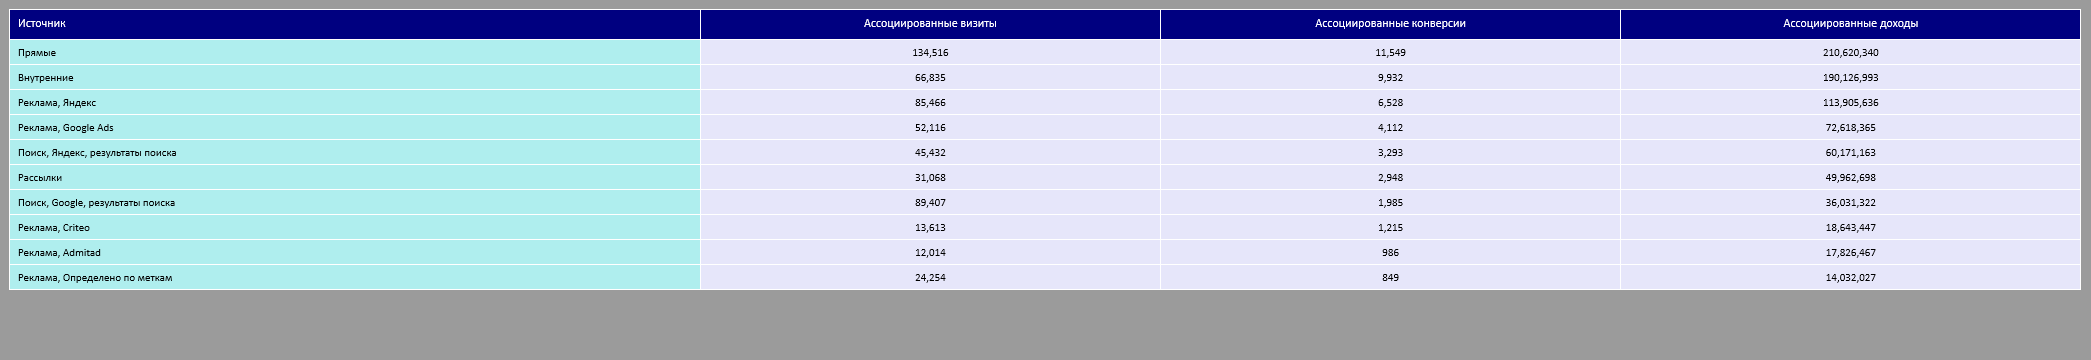

In [17]:
associated_conversions_formatted_df = associated_conversions_df[['SourceName', 'AssociatedVisits', 'AssociatedConvs', 'AssociatedRevenue']] \
    .sort_values('AssociatedConvs', ascending=False) \
    .rename(columns={'SourceName': 'Источник', 'AssociatedVisits': 'Ассоциированные визиты', 'AssociatedConvs': 'Ассоциированные конверсии', 
                     'AssociatedRevenue': 'Ассоциированные доходы'}) \
    .head(10)

associated_conversions_formatted_df['Ассоциированные доходы'] = associated_conversions_formatted_df['Ассоциированные доходы'].apply(lambda x: f"{x:,}")
associated_conversions_formatted_df['Ассоциированные конверсии'] = associated_conversions_formatted_df['Ассоциированные конверсии'].apply(lambda x: f"{x:,}")
associated_conversions_formatted_df['Ассоциированные визиты'] = associated_conversions_formatted_df['Ассоциированные визиты'].apply(lambda x: f"{x:,}")

plotly_pretty_table(associated_conversions_formatted_df, width=1000, height=340, columnwidth = [15, 10, 10, 10])


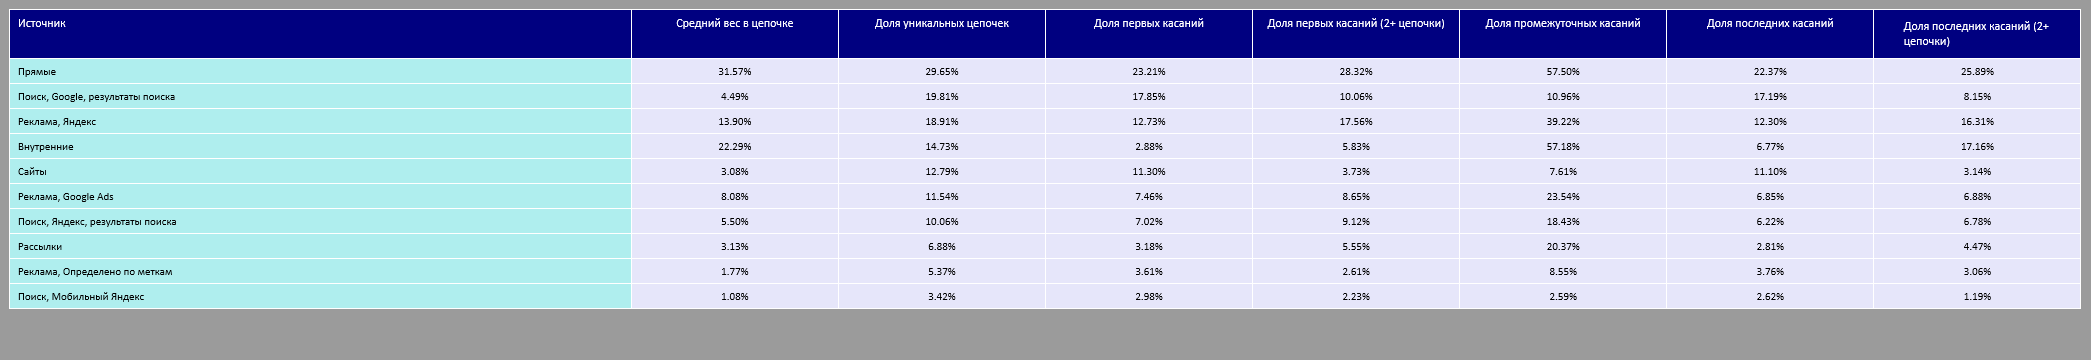

In [18]:
all_chains_formatted_df = source_in_chains_df[['SourceName', 'in_chain_perc_total', 'unique_chains_perc', 'first_touch_total', 'first_touch_2plus', 'mid_touch_3plus', 'last_touch_total', 'last_touch_2plus']] \
    .sort_values('unique_chains_perc', ascending=False) \
    .rename(columns={'SourceName': 'Источник', 'in_chain_perc_total': 'Средний вес в цепочке', 'unique_chains_perc': 'Доля уникальных цепочек', 
                     'first_touch_total': 'Доля первых касаний', 'first_touch_2plus': 'Доля первых касаний (2+ цепочки)', 
                     'mid_touch_3plus': 'Доля промежуточных касаний', 'last_touch_total': 'Доля последних касаний', 'last_touch_2plus': 'Доля последних касаний (2+ цепочки)'}) \
    .head(10)

all_chains_formatted_df['Средний вес в цепочке'] = all_chains_formatted_df['Средний вес в цепочке'].apply(lambda x: f"{x:.2%}")
all_chains_formatted_df['Доля уникальных цепочек'] = all_chains_formatted_df['Доля уникальных цепочек'].apply(lambda x: f"{x:.2%}")
all_chains_formatted_df['Доля первых касаний'] = all_chains_formatted_df['Доля первых касаний'].apply(lambda x: f"{x:.2%}")
all_chains_formatted_df['Доля первых касаний (2+ цепочки)'] = all_chains_formatted_df['Доля первых касаний (2+ цепочки)'].apply(lambda x: f"{x:.2%}")
all_chains_formatted_df['Доля промежуточных касаний'] = all_chains_formatted_df['Доля промежуточных касаний'].apply(lambda x: f"{x:.2%}")
all_chains_formatted_df['Доля последних касаний'] = all_chains_formatted_df['Доля последних касаний'].apply(lambda x: f"{x:.2%}")
all_chains_formatted_df['Доля последних касаний (2+ цепочки)'] = all_chains_formatted_df['Доля последних касаний (2+ цепочки)'].apply(lambda x: f"{x:.2%}")

plotly_pretty_table(all_chains_formatted_df, width=1000, height=340, columnwidth = [30, 10, 10, 10, 10, 10, 10, 10])


Теперь цепочки с конверсиями

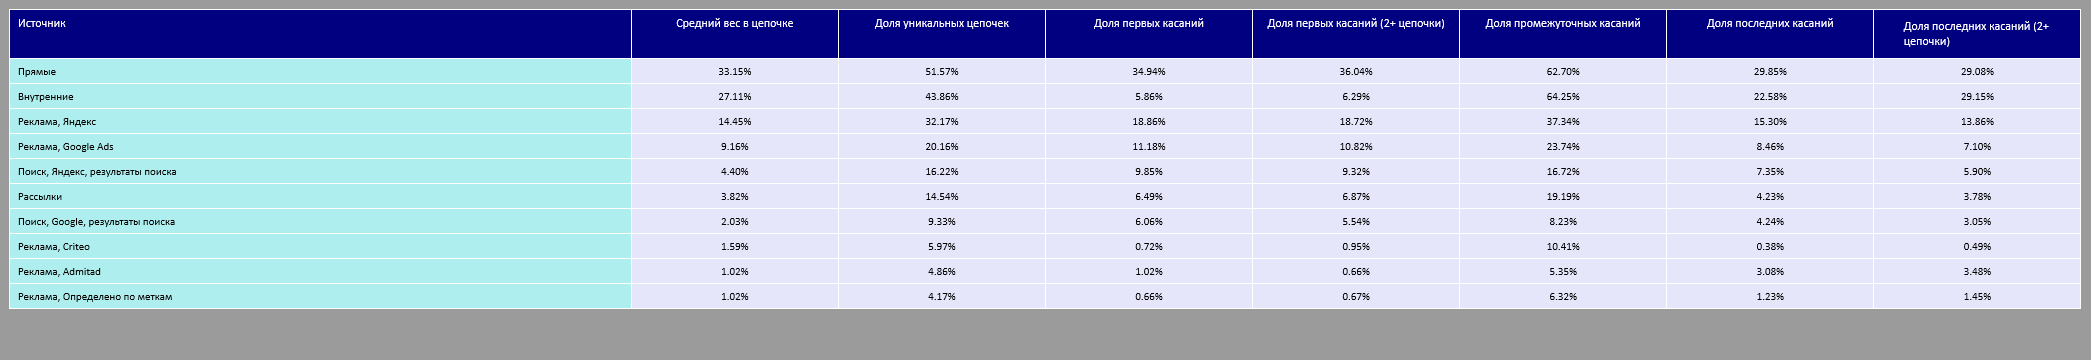

In [19]:
conv_chains_formatted_df = source_in_chains_df[['SourceName', 'in_conv_chains_perc_total', 'unique_conv_chains_perc', 'first_touch_conv_total', 'first_touch_conv_2plus', 'mid_touch_conv_3plus', 'last_touch_conv_total', 'last_touch_conv_2plus']] \
    .sort_values('unique_conv_chains_perc', ascending=False) \
    .rename(columns={'SourceName': 'Источник', 
                     'in_conv_chains_perc_total': 'Средний вес в цепочке', 
                     'unique_conv_chains_perc': 'Доля уникальных цепочек', 
                     'first_touch_conv_total': 'Доля первых касаний', 
                     'first_touch_conv_2plus': 'Доля первых касаний (2+ цепочки)', 
                     'mid_touch_conv_3plus': 'Доля промежуточных касаний', 
                     'last_touch_conv_total': 'Доля последних касаний', 
                     'last_touch_conv_2plus': 'Доля последних касаний (2+ цепочки)'}) \
    .head(10)

conv_chains_formatted_df['Средний вес в цепочке'] = conv_chains_formatted_df['Средний вес в цепочке'].apply(lambda x: f"{x:.2%}")
conv_chains_formatted_df['Доля уникальных цепочек'] = conv_chains_formatted_df['Доля уникальных цепочек'].apply(lambda x: f"{x:.2%}")
conv_chains_formatted_df['Доля первых касаний'] = conv_chains_formatted_df['Доля первых касаний'].apply(lambda x: f"{x:.2%}")
conv_chains_formatted_df['Доля первых касаний (2+ цепочки)'] = conv_chains_formatted_df['Доля первых касаний (2+ цепочки)'].apply(lambda x: f"{x:.2%}")
conv_chains_formatted_df['Доля промежуточных касаний'] = conv_chains_formatted_df['Доля промежуточных касаний'].apply(lambda x: f"{x:.2%}")
conv_chains_formatted_df['Доля последних касаний'] = conv_chains_formatted_df['Доля последних касаний'].apply(lambda x: f"{x:.2%}")
conv_chains_formatted_df['Доля последних касаний (2+ цепочки)'] = conv_chains_formatted_df['Доля последних касаний (2+ цепочки)'].apply(lambda x: f"{x:.2%}")

plotly_pretty_table(conv_chains_formatted_df, width=1000, height=340, columnwidth = [30, 10, 10, 10, 10, 10, 10, 10])

